### Code for Optimizing FATES Allometric Functions

#### Author: Katie Murenbeeld
#### Updated: 04 October 2021

### 1. Load Libraries


In [1]:
# Load appropriate libraries
import xarray as xr
import random
import numpy as np
import pandas as pd
import scipy as sp
import math as m
from scipy import optimize
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### 2. Define allometric functions that FATES currently uses

In [2]:
def d2h_chave2014(d,p1,p2,p3):
    h = np.exp( p1 + p2*np.log(d) + p3*np.log(d)**2.0)
    return(h)

def d2h_poorter2006(d,p1,p2,p3):
    h = p1*(1.0 - np.exp(p2*d**p3))
    return(h)

def d2h_2pwr(d,p1,p2):
    h = p1*d**p2
    return(h)

def d2h_obrien(d,p1,p2):
    h = 10.0**(np.log10(d)*p1+p2)
    return(h)

def d2h_martcano(d,p1,p2,p3):
    h = (p1*d**p2)/(p3+d**p2)
    return(h)

def carea_2pwr(d, p1, p2):
    c = p1 * d ** p2
    return(c)

def d2blmax_salda(d,p1,p2,p3,rho):
    blmax = p1 * d**p2 * rho**p3
    return(blmax)

def d2blmax_2pwr(d,p1,p2):
    c2b = 2.0
    blmax    = (p1*d**p2) / c2b
    return(blmax)

def d2bagw_choj(dbh,p1,p2):
    ln_agb = p1+(p2*np.log(dbh))
    agb_choj = np.exp(ln_agb)
    return agb_choj

def d2bagw_sal(dbh,p1,p2,p3,p4):
    agb_sal = allom_frac * p1 * (h_sal_mod**p2) * (dbh**p3) * (rho**p4)
    return agb_sal

def d2bagw_pow(dbh,p1,p2):
    agb_pow = (p1*np.power(dbh,p2))/c2b
    return agb_pow

### 3) Load data

Here we are using data from:

1. Falster et al., 2011 A Biomass and Allometry Database (BAAD)
2. USDA Forest Inventory Analysis (FIA) for Idaho
3. USDA Height and diameter at breast height (dbh) data from the Boise Basin Experimental Forest (BBEF)

We subset the data for Idaho or the western US. We are looking at common conifer species of Idaho. These include:

* Ponderosa pine (*Pinus ponderosa*)
* Lodgepole pine (*Pinus contorta*)
* Western white pine (*Pinus monticola*)
* Douglas-fir (*Pseudotsuga menziesii*)
* Western hemlock (*Tsuga heterophylla*)
* Western red cedar (*Thuja plicata*)
* Western larch (*Larix occidentalis*)
* Grand fir (*Abies grandis*)
* Subalpine fir (*Abies lasiocarpa*)
* Engelmann spruce (*Picea engelmanni*)

For this notebook, I am looking at the firs and spruce, which will comprise for PFT3, and W. Larch which will comprise PFT4.

In [3]:
# Set the directories
baad_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data/'
baad_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/baad_downloads/baad_data_out/'
bbef_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
bbef_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/BBEF/DATA/'
fia_dir = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID/'
fia_dir_out = '/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/Benchmarking_Sensitivity/FIA/FIA_ID_OUT/'

In [5]:
# Read in the BAAD data
baad_df = pd.read_csv(baad_dir + 'baad_data_2.csv').reset_index() 
baad_df = baad_df[['species', 'location', 'h.t', 'd.bh', 'a.lf', 'a.cp', 'm.lf', 'ma.ilf', 'n.lf', 'm.so']].copy()

# Read in the BBEF data
bbef_df = pd.read_csv(bbef_dir + 'BBEF-all-trees-height_DBH_calcs.csv')

# Read in the FIA Idaho census data
fia_df = pd.read_csv(fia_dir + 'ID_TREE.csv')
fia_df = fia_df[['PLT_CN', 'COUNTYCD', 'INVYR', 'CONDID', 'AZIMUTH', 'SPCD', 'SPGRPCD', 
                       'DIA', 'HT', 'CR', 'CDENCD', 'BHAGE', 'FGROWCFGS', 'TPA_UNADJ',  
                       'DRYBIO_BG', 'CARBON_AG', 'CARBON_BG', 'DRYBIO_AG']].copy()

/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
bbef_df['Species'].unique()

array(['Ponderosa pine', 'Douglas fir', 'Aspen', 'Lodgepole pine',
       'Subalpine fir', 'Grand fir'], dtype=object)

In [24]:
# For each dataset sort out for the 10 conifer species of interest for the SCGSR work. Scratch that. 
# Just the species for PFT1 ( 3 pine species) and PFT 4 (W. Hemlock and Douglas Fir).

baad_pft3 = baad_df.loc[(baad_df['species'] == 'Abies grandis') | (baad_df['species'] == 'Abies lasiocarpa') | (baad_df['species'] == 'Picea engelmanni') | (baad_df['species'] == 'Thuja plicata')].copy()
baad_pft4 = baad_df.loc[(baad_df['species'] == 'Larix occidentalis')].copy()

bbef_pft3 = bbef_df.loc[(bbef_df['Species'] == 'Grand fir') | (bbef_df['Species'] == 'Subalpine fir')].copy()
#bbef_pft4 = bbef_df.loc[(bbef_df['Species'] == 'Western larch')].copy()

fia_pft3 = fia_df.loc[(fia_df['SPECIES'] == 'grand_fir') | (fia_df['SPECIES'] == 'subap_fir') | (fia_df['SPECIES'] == 'w_redcedar') | (fia_df['SPECIES'] == 'engle_spruce')].copy()
fia_pft4 = fia_df.loc[(fia_df['SPECIES'] == 'doug-fir') | (fia_df['SPECIES'] == 'w_larch')].copy()


In [25]:
# Clean up and convert USDA FS data to metric 
baad_pft3['DBH (cm)'] = baad_pft3['d.bh']*100
baad_pft4['DBH (cm)'] = baad_pft4['d.bh']*100

bbef_pft3['DBH (m)'] = bbef_pft3['DBH (cm)']/100
bbef_pft3 = bbef_pft3.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])
#bbef_pft4['DBH (m)'] = bbef_pft4['DBH (cm)']/100
#bbef_pft4 = bbef_pft4.drop(columns = ['Unnamed: 10', 'Unnamed: 11', 'param 1', 'param 2'])

fia_pft3['HT (m)'] = fia_pft3['HT'] * 0.3048
fia_pft3['DBH (cm)'] = fia_pft3['DIA'] * 2.54
fia_pft3['DBH (m)'] = fia_pft3['DIA'] * 0.0254
fia_pft4['HT (m)'] = fia_pft4['HT'] * 0.3048
fia_pft4['DBH (cm)'] = fia_pft4['DIA'] * 2.54
fia_pft4['DBH (m)'] = fia_pft4['DIA'] * 0.0254

In [26]:
baad_pft3.head(2)
#bbef_2pfts

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3426,Thuja plicata,northern Rocky Mountains U.S.A.,0.54864,NaN,NaN,0.143013,0.029983,NaN,NaN,NaN,NaN
3429,Abies lasiocarpa,northern Rocky Mountains U.S.A.,0.76200,NaN,NaN,0.493249,0.163024,NaN,NaN,NaN,NaN


In [27]:
# Review the max and min height by location (BAAD only)
print("max = ", baad_pft3.groupby('location')['h.t'].max(), "\nmin = ", baad_pft3.groupby('location')['h.t'].min())
print("max = ", baad_pft4.groupby('location')['h.t'].max(), "\nmin = ", baad_pft4.groupby('location')['h.t'].min())


max =  location
24 km east of Prince George, British Columbia, CA     6.9360
Gavin Lake                                            5.8200
Pringle Butte and Lookout Mountain                   14.5200
northern Rocky Mountains U.S.A.                      38.5572
Name: h.t, dtype: float64 
min =  location
24 km east of Prince George, British Columbia, CA    0.68200
Gavin Lake                                           0.29000
Pringle Butte and Lookout Mountain                   2.16000
northern Rocky Mountains U.S.A.                      0.54864
Name: h.t, dtype: float64
max =  location
northern Rocky Mountains U.S.A.    15.27048
Name: h.t, dtype: float64 
min =  location
northern Rocky Mountains U.S.A.    0.85344
Name: h.t, dtype: float64


In [28]:
# Review the mean height by location (BAAD only)
print("mean\n", baad_pft3.groupby('location')['h.t'].mean())
print("mean\n", baad_pft4.groupby('location')['h.t'].mean())


mean
 location
24 km east of Prince George, British Columbia, CA    2.670767
Gavin Lake                                           1.890029
Pringle Butte and Lookout Mountain                   8.086522
northern Rocky Mountains U.S.A.                      8.053754
Name: h.t, dtype: float64
mean
 location
northern Rocky Mountains U.S.A.    4.453467
Name: h.t, dtype: float64


In [29]:
# Review basic stats on height
print("BAAD\n", baad_pft3['h.t'].describe(), "\nBBEF", bbef_pft3['H (m)'].describe(), "\nFIA", fia_pft3['HT (m)'].describe())

# There is no way there is a 269 m tall tree at BBEF


BAAD
 count    516.00000
mean       3.60921
std        5.13665
min        0.29000
25%        1.06000
50%        2.16000
75%        3.43000
max       38.55720
Name: h.t, dtype: float64 
BBEF count     9.000000
mean     17.106053
std       6.549651
min       8.229600
25%      13.106400
50%      14.630400
75%      20.970240
max      27.127200
Name: H (m), dtype: float64 
FIA count    95351.000000
mean        15.925820
std          8.636624
min          0.914400
25%          9.753600
50%         14.935200
75%         21.336000
max         65.532000
Name: HT (m), dtype: float64


In [30]:
print("BAAD\n", baad_pft4['h.t'].describe(), "\nBBEF", "\nFIA", fia_pft4['HT (m)'].describe())


BAAD
 count    18.000000
mean      4.453467
std       4.125761
min       0.853440
25%       1.623060
50%       3.550920
75%       5.219700
max      15.270480
Name: h.t, dtype: float64 
BBEF 
FIA count    63142.000000
mean        18.333496
std          8.152820
min          0.304800
25%         12.192000
50%         17.678400
75%         23.774400
max         62.179200
Name: HT (m), dtype: float64


In [31]:
# Review basic stats on dbh
print("BAAD\n", baad_pft3['d.bh'].describe(), "\nBBEF", bbef_pft3['DBH (m)'].describe(), "\nFIA", fia_pft3['DBH (m)'].describe())
print("BAAD\n", baad_pft4['d.bh'].describe(), "\nBBEF", "\nFIA", fia_pft4['DBH (m)'].describe())



BAAD
 count    142.000000
mean       0.115042
std        0.126048
min        0.002540
25%        0.027010
50%        0.067290
75%        0.165075
max        0.675640
Name: d.bh, dtype: float64 
BBEF count    9.000000
mean     0.321451
std      0.095420
min      0.162560
25%      0.304800
50%      0.325120
75%      0.381000
max      0.457200
Name: DBH (m), dtype: float64 
FIA count    95351.000000
mean         0.236550
std          0.157255
min          0.025400
25%          0.142240
50%          0.200660
75%          0.302260
max          2.405380
Name: DBH (m), dtype: float64
BAAD
 count    14.000000
mean      0.054791
std       0.046460
min       0.005080
25%       0.020955
50%       0.045720
75%       0.069215
max       0.167640
Name: d.bh, dtype: float64 
BBEF 
FIA count    63142.000000
mean         0.311489
std          0.186707
min          0.025400
25%          0.175260
50%          0.269240
75%          0.403860
max          1.684020
Name: DBH (m), dtype: float64


In [32]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBHpft3 = pd.concat([baad_pft3['d.bh'], bbef_pft3['DBH (m)'], fia_pft3['DBH (m)']], axis=0, ignore_index=True)
TOT_Hpft3 = pd.concat([baad_pft3['h.t'], bbef_pft3['H (m)'], fia_pft3['HT (m)']], axis=0, ignore_index=True)

TOTpft3 = pd.concat([pd.DataFrame(TOT_DBHpft3, columns=['DBH(m)']), pd.DataFrame(TOT_Hpft3, columns=['H(m)'])], axis=1)
TOTpft3['DBH(cm)'] = TOTpft3['DBH(m)'] * 100
TOTpft3

,DBH(m),H(m),DBH(cm)
0,NaN,0.54864,NaN
1,NaN,0.76200,NaN
2,NaN,0.91440,NaN
3,NaN,0.94488,NaN
4,NaN,1.09728,NaN
...,...,...,...
100974,NaN,NaN,NaN
100975,NaN,NaN,NaN
100976,NaN,NaN,NaN
100977,NaN,NaN,NaN


In [33]:
# Combine all of the DBH and H datasets into one dataframe
TOT_DBHpft4 = pd.concat([baad_pft4['d.bh'], fia_pft4['DBH (m)']], axis=0, ignore_index=True)
TOT_Hpft4 = pd.concat([baad_pft4['h.t'], fia_pft4['HT (m)']], axis=0, ignore_index=True)

TOTpft4 = pd.concat([pd.DataFrame(TOT_DBHpft4, columns=['DBH(m)']), pd.DataFrame(TOT_Hpft4, columns=['H(m)'])], axis=1)
TOTpft4['DBH(cm)'] = TOTpft4['DBH(m)'] * 100
TOTpft4

,DBH(m),H(m),DBH(cm)
0,NaN,0.85344,NaN
1,NaN,1.09728,NaN
2,NaN,1.37160,NaN
3,NaN,1.37160,NaN
4,0.01270,1.52400,1.270
...,...,...,...
65724,1.08966,24.38400,108.966
65725,0.38862,20.42160,38.862
65726,0.40386,17.67840,40.386
65727,0.38354,14.32560,38.354


In [17]:
######################
## DO NOT DO #########
## NOT NECESSARY #####
######################

# Find the mean height for specified ranges of DBH. 
# Here for a dbh of 10cm I took the measurements from 5-15cm to represent 10cm dbh. 
# Repeat the process up to 90cm.
# These values will be used to calculate parameters from the allometric equations (this acutally may not be necessary)

# Set dbh_mod to the ranges of dbh needed for calculation. In this case I want an array from 10-90 in steps of 10.
dbh_mod = np.arange(10, 100, 10) 

baad_mean_h = []

for i in dbh_mod:
    mask =  (baad_2pfts['d.bh']>= ((i/100) - 0.05)) & (baad_2pfts['d.bh']<((i/100) + 0.05))
    tmp_ = baad_2pfts.loc[mask].copy()
    stats = tmp_['h.t'].mean()
    baad_mean_h.append(stats)
    
bbef_mean_h = []

for i in dbh_mod:
    mask =  (bbef_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (bbef_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = bbef_2pfts.loc[mask].copy()
    stats = tmp_['H (m)'].mean()
    bbef_mean_h.append(stats)

fia_mean_h = []

for i in dbh_mod:
    mask =  (fia_2pfts['DBH (m)']>= ((i/100) - 0.05)) & (fia_2pfts['DBH (m)']<((i/100) + 0.05))
    tmp_ = fia_2pfts.loc[mask].copy()
    stats = tmp_['HT (m)'].mean()
    fia_mean_h.append(stats)
    
tot_mean_h = []

for i in dbh_mod:
    mask =  (TOT['DBH(m)']>= ((i/100) - 0.05)) & (TOT['DBH(m)']<((i/100) + 0.05))
    tot_ = TOT.loc[mask].copy()
    stats = tot_['H(m)'].mean()
    tot_mean_h.append(stats)

### 3) Fit parameters for the allometric functions using curve_fit()


In [34]:
## Create a vector or dataframe with the height and dbh values for each of the three datasets and for the combined 
## (TOT) dataset

BBEF_DBHpft3 = bbef_pft3['DBH (cm)'].values
BAAD_DBHpft3 = baad_pft3['DBH (cm)'].values
FIA_DBHpft3 = fia_pft3['DBH (cm)'].values
TOT_DBHpft3 = TOTpft3['DBH(cm)'].values

BBEF_Hpft3 = bbef_pft3['H (m)'].values
BAAD_Hpft3 = baad_pft3['h.t'].values
FIA_Hpft3 = fia_pft3['HT (m)'].values
TOT_Hpft3 = TOTpft3['H(m)'].values

#BAAD_Hobspft1 = baad_mean_h
#BBEF_Hobspft1 = bbef_mean_h
#FIA_Hobspft1 = fia_mean_h
#TOT_Hobspft1 = tot_mean_h


In [35]:
# If you would like you can define an objective/cost function for the d2h function. In this case RMSE.
# Then I want to create an objective function. I will use RMSE

def d2h_error(dbh,Hobs,p1,p2):
    h = 10**((np.log10(dbh))*p1+p2)
    RMSE = np.sqrt(np.mean((h-Hobs)**2)) # best to use numpy
    return RMSE

In [36]:
RMSE = d2h_error(10,6.24,0.65,0.18)
print(RMSE)

0.520829753919819


### 3.1) For the d2h allometries fit the data to all of the functions. Then just the datasets to the O'Brien function.

We will also randomly sample and optimize the parameters to get a distribution of p1 and p2 for the O'Brien equation.

[0.69537932 0.2692874 ]
[ 4.22579507e+01 -1.83936797e-02  1.05881025e+00]
[1.85904684 0.69537738]
[-1.08741381  1.70855793 -0.14633138]
[54.76481112  1.16878491 87.2249105 ]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


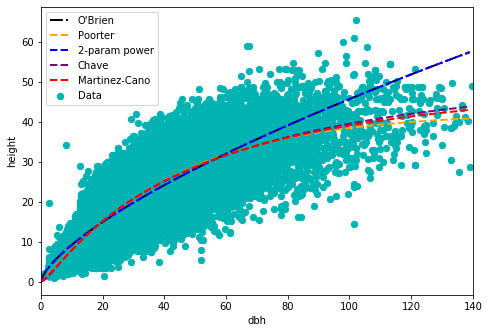

In [38]:
TOTpft3_na = TOTpft3.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOTpft3_na['DBH(cm)'].dropna(), ydata=TOTpft3_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOTpft3_na['DBH(cm)'].dropna(), ydata=TOTpft3_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOTpft3_na['DBH(cm)'].dropna(), ydata=TOTpft3_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOTpft3_na['DBH(cm)'].dropna(), ydata=TOTpft3_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOTpft3_na['DBH(cm)'].dropna(), ydata=TOTpft3_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOTpft3['DBH(cm)'], TOTpft3['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")
ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

[0.84265876 0.05282029]
[ 0.91857358 -0.15060192]
[0.69522631 0.26953541]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


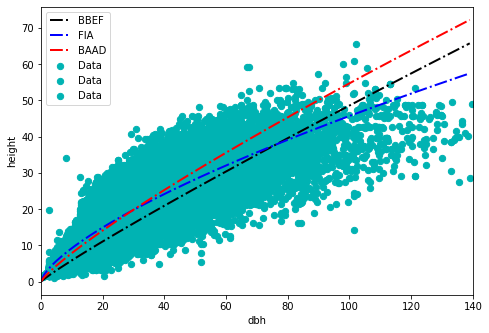

In [40]:
# Just using the O'Brien equation. Create optimal parameters for each of the three datasets.

baad_pft3na = baad_pft3.dropna(subset=['DBH (cm)'])
parsbaad_obrien, covbaad_obrien = curve_fit(f=d2h_obrien, xdata=baad_pft3na['DBH (cm)'], ydata=baad_pft3na['h.t'])
print(parsbaad_obrien)
parsbbef_obrien, covbbef_obrien = curve_fit(f=d2h_obrien, xdata=BBEF_DBHpft3, ydata=BBEF_Hpft3)
print(parsbbef_obrien)
parsfia_obrien, covfia_obrien = curve_fit(f=d2h_obrien, xdata=fia_pft3['DBH (cm)'].dropna(), ydata=fia_pft3['HT (m)'].dropna())
print(parsfia_obrien)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(fia_pft3['DBH (cm)'], fia_pft3['HT (m)'], s=40, color='#00b3b3', label='Data')
ax.scatter(BBEF_DBHpft3, BBEF_Hpft3, s=40, color='#00b3b3', label='Data')
ax.scatter(baad_pft3['DBH (cm)'], baad_pft3['h.t'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbbef_obrien), linestyle='-.', linewidth=2, color='black', label="BBEF")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsfia_obrien), linestyle='-.', linewidth=2, color='blue', label="FIA")
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *parsbaad_obrien), linestyle='-.', linewidth=2, color='red', label="BAAD")
ax.set_xlim(0,140)
ax.legend()



[-0.21541358  1.07061912 -0.0364875 ]
[ 5.90693304 -2.83472921  0.55821746]
[-1.08844484  1.70922936 -0.14643492]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


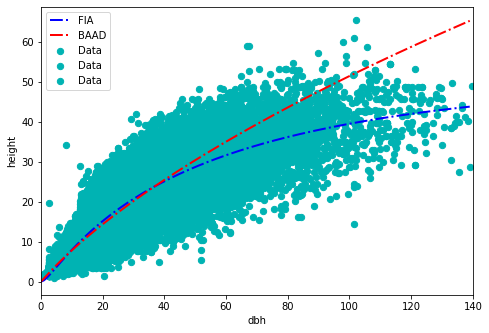

In [42]:
## The Chave equation seems to work better

baad_pft3na = baad_pft3.dropna(subset=['DBH (cm)'])
parsbaad_chave, covbaad_chave = curve_fit(f=d2h_chave2014, xdata=baad_pft3na['DBH (cm)'], ydata=baad_pft3na['h.t'])
print(parsbaad_chave)
parsbbef_chave, covbbef_chave = curve_fit(f=d2h_chave2014, xdata=BBEF_DBHpft3, ydata=BBEF_Hpft3)
print(parsbbef_chave)
parsfia_chave, covfia_chave = curve_fit(f=d2h_chave2014, xdata=fia_pft3['DBH (cm)'].dropna(), ydata=fia_pft3['HT (m)'].dropna())
print(parsfia_chave)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(fia_pft3['DBH (cm)'], fia_pft3['HT (m)'], s=40, color='#00b3b3', label='Data')
ax.scatter(BBEF_DBHpft3, BBEF_Hpft3, s=40, color='#00b3b3', label='Data')
ax.scatter(baad_pft3['DBH (cm)'], baad_pft3['h.t'], s=40, color='#00b3b3', label='Data')
#ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *parsbbef_chave), linestyle='-.', linewidth=2, color='black', label="BBEF")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *parsfia_chave), linestyle='-.', linewidth=2, color='blue', label="FIA")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *parsbaad_chave), linestyle='-.', linewidth=2, color='red', label="BAAD")
ax.set_xlim(0,140)
ax.legend()

In [43]:
# From the total dataset, sample 1000 random samples and calculate the optimal parameters for O'Brien.
# Repeat the sampling and optimization 100 times.
# Create histograms for the two parameters.

smp_opt_d2h = []

def d2h_params(data):
    smp_mean_h = []
    for i in dbh_mod:
        smp = data.sample(1000).dropna()
            
    smp_opt, smp_cov = curve_fit(f=d2h_obrien, xdata=smp['DBH(cm)'], ydata=smp['H(m)'])
    smp_opt_d2h.append(smp_opt)
    return smp_opt

In [44]:
TOTpft3.sample(1000).dropna()

,DBH(m),H(m),DBH(cm)
54822,0.15494,13.1064,15.494
21804,0.38100,28.3464,38.100
73214,0.02794,2.1336,2.794
94852,0.13716,8.8392,13.716
62934,0.27686,15.5448,27.686
...,...,...,...
32427,0.03556,3.3528,3.556
36626,0.17272,20.7264,17.272
47524,0.34544,27.7368,34.544
31235,0.33274,17.3736,33.274


In [45]:
dbh_mod = np.arange(10, 100, 10)

smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOTpft3)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_dfpft3 = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 2.,  2.,  4.,  9., 20., 26., 21., 11.,  4.,  1.]),
 array([0.64116054, 0.65181426, 0.66246799, 0.67312171, 0.68377543,
        0.69442915, 0.70508287, 0.71573659, 0.72639032, 0.73704404,
        0.74769776]),
 <a list of 10 Patch objects>)

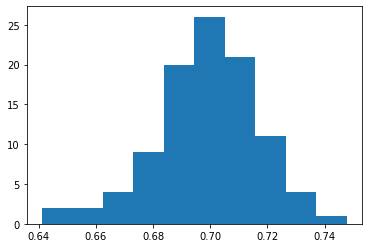

In [47]:
plt.hist(d2h_params_dfpft3['d2h_p1'])

(array([ 1.,  2., 10., 13., 35., 19., 12.,  3.,  3.,  2.]),
 array([0.19151222, 0.20675355, 0.22199489, 0.23723622, 0.25247755,
        0.26771888, 0.28296022, 0.29820155, 0.31344288, 0.32868421,
        0.34392555]),
 <a list of 10 Patch objects>)

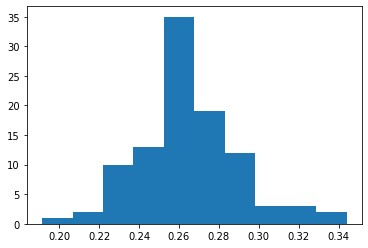

In [48]:
plt.hist(d2h_params_dfpft3['d2h_p2'])

In [49]:
# read out to a csv for use in the traits matrix
#d2h_params_dfpft3.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2h_params_PFT3_20211004.csv', index=False)


#### Now repeat for PFT 4

[0.54274717 0.47374842]
[ 3.09917188e+01 -2.50496389e-02  1.09055582e+00]
[2.9768267  0.54274392]
[-1.33573103  1.94102312 -0.19690414]
[36.69873566  1.30602209 71.93353042]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


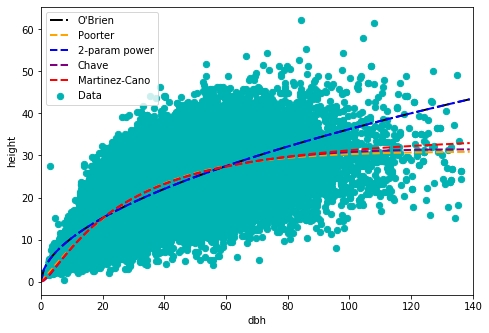

In [50]:
TOTpft4_na = TOTpft4.dropna(subset = ['DBH(cm)', 'H(m)']).copy()

pars_obrien, cov_obrien = curve_fit(f=d2h_obrien, xdata=TOTpft4_na['DBH(cm)'].dropna(), ydata=TOTpft4_na['H(m)'].dropna())
print(pars_obrien)
pars_poorter2006, cov_poorter2006 = curve_fit(f=d2h_poorter2006, xdata=TOTpft4_na['DBH(cm)'].dropna(), ydata=TOTpft4_na['H(m)'].dropna(), p0=[10,-0.01,1])
print(pars_poorter2006)
pars_2pwr, cov_2pwr = curve_fit(f=d2h_2pwr, xdata=TOTpft4_na['DBH(cm)'].dropna(), ydata=TOTpft4_na['H(m)'].dropna())
print(pars_2pwr)
pars_chave2014, cov_chave2014 = curve_fit(f=d2h_chave2014, xdata=TOTpft4_na['DBH(cm)'].dropna(), ydata=TOTpft4_na['H(m)'].dropna())
print(pars_chave2014)
pars_martcano, cov_martcano = curve_fit(f=d2h_martcano, xdata=TOTpft4_na['DBH(cm)'].dropna(), ydata=TOTpft4_na['H(m)'].dropna(), p0=[10,1,100])
print(pars_martcano)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('height')
ax.scatter(TOTpft4['DBH(cm)'], TOTpft4['H(m)'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2h_obrien(np.arange(140), *pars_obrien), linestyle='-.', linewidth=2, color='black', label="O'Brien")
ax.plot(np.arange(140), d2h_poorter2006(np.arange(140), *pars_poorter2006), linestyle='--', linewidth=2, color='orange', label="Poorter")
ax.plot(np.arange(140), d2h_2pwr(np.arange(140), *pars_2pwr), linestyle='--', linewidth=2, color='blue', label="2-param power")
ax.plot(np.arange(140), d2h_chave2014(np.arange(140), *pars_chave2014), linestyle='--', linewidth=2, color='purple', label="Chave")
ax.plot(np.arange(140), d2h_martcano(np.arange(140), *pars_martcano), linestyle='--', linewidth=2, color='red', label="Martinez-Cano")
ax.set_xlim(0,140)
ax.legend()

In [51]:
dbh_mod = np.arange(10, 100, 10)

smp_opt_d2h = []

for x in range(1,101):
    d2h_params(TOTpft4)
    D2H_PARAMS_DF = smp_opt_d2h

d2h_params_dfpft4 = pd.DataFrame(D2H_PARAMS_DF, columns=['d2h_p1', 'd2h_p2'])

(array([ 4.,  9., 12., 11., 19., 14., 15.,  9.,  5.,  2.]),
 array([0.50586156, 0.51383339, 0.52180521, 0.52977703, 0.53774886,
        0.54572068, 0.55369251, 0.56166433, 0.56963615, 0.57760798,
        0.5855798 ]),
 <a list of 10 Patch objects>)

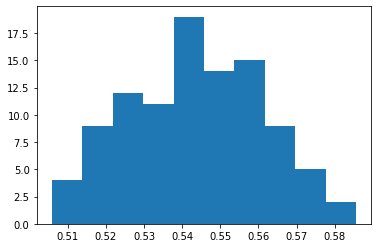

In [52]:
plt.hist(d2h_params_dfpft4['d2h_p1'])

(array([ 1.,  7.,  9., 15., 14., 16., 14., 13.,  7.,  4.]),
 array([0.41026595, 0.42214167, 0.43401739, 0.44589311, 0.45776883,
        0.46964455, 0.48152027, 0.49339599, 0.50527171, 0.51714743,
        0.52902314]),
 <a list of 10 Patch objects>)

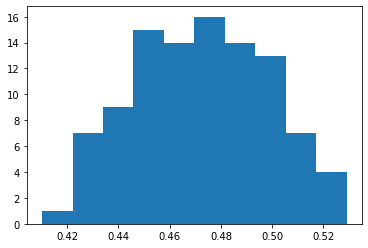

In [53]:
plt.hist(d2h_params_dfpft4['d2h_p2'])

In [54]:
# read out to a csv for use in the traits matrix
#d2h_params_dfpft4.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2h_params_PFT4_20211004.csv', index=False)

### 3.2) We will optimize for the leaf biomass and crown area allometries using the BAAD data. 

#### First, projected crown area ($m^2$)

In [55]:
baad_pft3.dropna(subset=['a.cp', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3480,Thuja plicata,northern Rocky Mountains U.S.A.,1.43256,0.00762,NaN,1.349139,0.156991,NaN,NaN,NaN,0.762
3484,Thuja plicata,northern Rocky Mountains U.S.A.,1.58496,0.00254,NaN,1.681134,0.247983,NaN,NaN,NaN,0.254
3487,Abies grandis,northern Rocky Mountains U.S.A.,1.61544,0.00762,NaN,1.477559,0.135989,NaN,NaN,NaN,0.762
3490,Abies lasiocarpa,northern Rocky Mountains U.S.A.,1.64592,0.00762,NaN,0.420283,0.374991,NaN,NaN,NaN,0.762
3491,Thuja plicata,northern Rocky Mountains U.S.A.,1.64592,0.00254,NaN,0.794598,0.300011,NaN,NaN,NaN,0.254
...,...,...,...,...,...,...,...,...,...,...,...
6643,Abies grandis,Pringle Butte and Lookout Mountain,3.89000,0.04900,11.9682,1.130973,1.780000,NaN,NaN,NaN,4.900
6644,Abies grandis,Pringle Butte and Lookout Mountain,10.07000,0.21500,221.7060,9.348202,36.600000,NaN,NaN,NaN,21.500
6645,Abies grandis,Pringle Butte and Lookout Mountain,6.59000,0.09400,41.0930,2.986477,6.240000,NaN,NaN,NaN,9.400
6646,Abies grandis,Pringle Butte and Lookout Mountain,7.95000,0.11500,32.2422,5.515459,4.890000,NaN,NaN,NaN,11.500


[0.28917627 1.22419479]


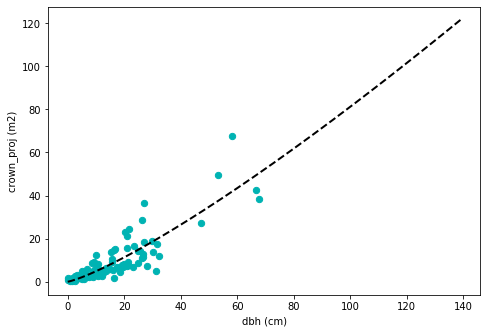

In [56]:
baad_acppft3 = baad_pft3.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars, crownarea_cov = curve_fit(f=carea_2pwr, xdata=baad_acppft3['DBH (cm)'], ydata=baad_acppft3['a.cp'])
print(crownarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft3['DBH (cm)'], baad_acppft3['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars), linestyle='--', linewidth=2, color='black')


(array([131.,  84.,  26.,  14.,   6.,   9.,   6.,   1.,   3.,   2.,   4.,
          3.,   2.,   1.,   1.,   1.,   0.,   1.,   1.,   0.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.88691909e-02, 1.36713470e+00, 2.71540022e+00, 4.06366573e+00,
        5.41193125e+00, 6.76019676e+00, 8.10846227e+00, 9.45672779e+00,
        1.08049933e+01, 1.21532588e+01, 1.35015243e+01, 1.48497898e+01,
        1.61980554e+01, 1.75463209e+01, 1.88945864e+01, 2.02428519e+01,
        2.15911174e+01, 2.29393829e+01, 2.42876484e+01, 2.56359140e+01,
        2.69841795e+01, 2.83324450e+01, 2.96807105e+01, 3.10289760e+01,
        3.23772415e+01, 3.37255070e+01, 3.50737725e+01, 3.64220381e+01,
        3.77703036e+01, 3.91185691e+01, 4.04668346e+01, 4.18151001e+01,
        4.31633656e+01, 4.45116311e+01, 4.58598967e+01, 4.72081622e+01,
        4.

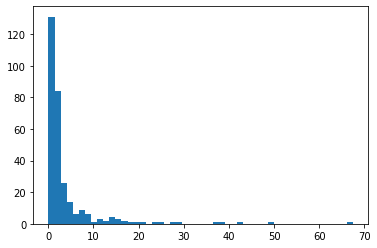

In [57]:
plt.hist(baad_pft3['a.cp'].dropna(), bins=50)

In [58]:
baad_pft3['a.cp'].describe()

count    303.000000
mean       3.779078
std        7.318839
min        0.018869
25%        0.572052
50%        1.583677
75%        3.312276
max       67.432145
Name: a.cp, dtype: float64

In [59]:
acppft3_log = np.log(baad_pft3['a.cp'])
acppft3_log.describe()

count    303.000000
mean       0.348389
std        1.438753
min       -3.970225
25%       -0.558525
50%        0.459749
75%        1.197574
max        4.211122
Name: a.cp, dtype: float64

#### Then, leaf area ($m^2$)

In [60]:
baad_pft3.dropna(subset=['a.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
6625,Abies grandis,Pringle Butte and Lookout Mountain,7.26,0.108,53.3446,2.717163,8.09,NaN,NaN,NaN,10.8
6626,Abies grandis,Pringle Butte and Lookout Mountain,8.06,0.135,70.7192,6.157522,11.02,NaN,NaN,NaN,13.5
6627,Abies grandis,Pringle Butte and Lookout Mountain,4.04,0.043,5.8424,2.269801,0.84,NaN,NaN,NaN,4.3
6628,Abies grandis,Pringle Butte and Lookout Mountain,12.94,0.161,89.9468,5.350211,14.09,NaN,NaN,NaN,16.1
6629,Abies grandis,Pringle Butte and Lookout Mountain,13.02,0.247,234.4154,8.552986,38.02,NaN,NaN,NaN,24.7
6630,Abies grandis,Pringle Butte and Lookout Mountain,7.83,0.135,73.6186,5.107052,11.55,NaN,NaN,NaN,13.5
6631,Abies grandis,Pringle Butte and Lookout Mountain,9.81,0.198,234.3064,8.295768,38.45,NaN,NaN,NaN,19.8
6632,Abies grandis,Pringle Butte and Lookout Mountain,14.52,0.268,251.8118,11.641564,41.38,NaN,NaN,NaN,26.8
6633,Abies grandis,Pringle Butte and Lookout Mountain,4.25,0.044,8.5020,1.886919,1.23,NaN,NaN,NaN,4.4
6634,Abies grandis,Pringle Butte and Lookout Mountain,8.45,0.116,39.1746,3.801327,5.96,NaN,NaN,NaN,11.6


[0.45889076 1.96269681]


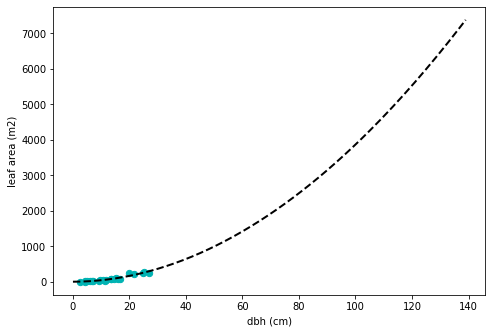

In [61]:
baad_alfpft3 = baad_pft3.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars, leafarea_cov = curve_fit(f=carea_2pwr, xdata=baad_alfpft3['DBH (cm)'], ydata=baad_alfpft3['a.lf'])
print(leafarea_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alfpft3['DBH (cm)'], baad_alfpft3['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

(array([73.,  3.,  3.,  1.,  4.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,
         1.,  1.]),
 array([8.49252770e-02, 1.84581169e+01, 3.68313086e+01, 5.52045002e+01,
        7.35776919e+01, 9.19508835e+01, 1.10324075e+02, 1.28697267e+02,
        1.47070458e+02, 1.65443650e+02, 1.83816842e+02, 2.02190033e+02,
        2.20563225e+02, 2.38936417e+02, 2.57309608e+02, 2.75682800e+02]),
 <a list of 15 Patch objects>)

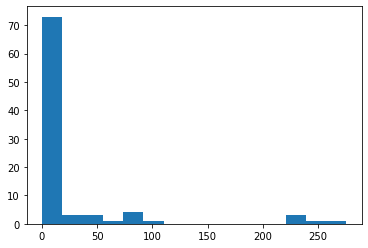

In [62]:
plt.hist(baad_pft3['a.lf'].dropna(), bins=15)

In [63]:
baad_pft3['a.lf'].describe()

count     90.000000
mean      23.463659
std       58.072179
min        0.084925
25%        0.646128
50%        1.405603
75%        8.214524
max      275.682800
Name: a.lf, dtype: float64

In [64]:
alfpft3_log = np.log(baad_pft3['a.lf'])
alfpft3_log.describe()

count    90.000000
mean      0.878136
std       2.120348
min      -2.465984
25%      -0.436833
50%       0.340455
75%       2.105688
max       5.619251
Name: a.lf, dtype: float64

#### Calculate the leaf crown exponent difference

In [65]:
leaf_crown_exponent_diff = crownarea_pars[1] - leafarea_pars[1]
print(leaf_crown_exponent_diff)

-0.7385020169083085


#### Next, the leaf mass (kg)

In [66]:
baad_pft3.dropna(subset=['m.lf', 'DBH (cm)'])

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)
3480,Thuja plicata,northern Rocky Mountains U.S.A.,1.43256,0.00762,NaN,1.349139,0.156991,NaN,NaN,NaN,0.762
3484,Thuja plicata,northern Rocky Mountains U.S.A.,1.58496,0.00254,NaN,1.681134,0.247983,NaN,NaN,NaN,0.254
3487,Abies grandis,northern Rocky Mountains U.S.A.,1.61544,0.00762,NaN,1.477559,0.135989,NaN,NaN,NaN,0.762
3490,Abies lasiocarpa,northern Rocky Mountains U.S.A.,1.64592,0.00762,NaN,0.420283,0.374991,NaN,NaN,NaN,0.762
3491,Thuja plicata,northern Rocky Mountains U.S.A.,1.64592,0.00254,NaN,0.794598,0.300011,NaN,NaN,NaN,0.254
...,...,...,...,...,...,...,...,...,...,...,...
19395,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",2.43000,0.02510,NaN,NaN,0.536340,NaN,NaN,1.18675,2.510
19396,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",5.29000,0.06560,NaN,NaN,0.985780,NaN,NaN,4.51192,6.560
19397,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",6.93600,0.06540,NaN,NaN,0.845220,NaN,NaN,6.65497,6.540
19398,Abies lasiocarpa,"24 km east of Prince George, British Columbia, CA",5.45000,0.06290,NaN,NaN,0.781350,NaN,NaN,5.25157,6.290


[0.22477839 1.46557942]


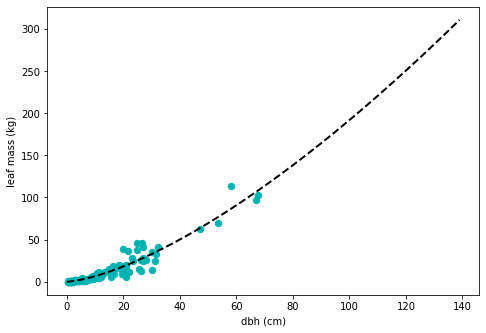

In [67]:
# dbh to crown area eq.
baad_mlfpft3 = baad_pft3.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars, leafmass_cov = curve_fit(f=carea_2pwr, xdata=baad_mlfpft3['DBH (cm)'], ydata=baad_mlfpft3['m.lf'])
print(leafmass_pars)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft3['DBH (cm)'], baad_mlfpft3['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_pars), linestyle='--', linewidth=2, color='black')

[0.44955559 1.46558012]


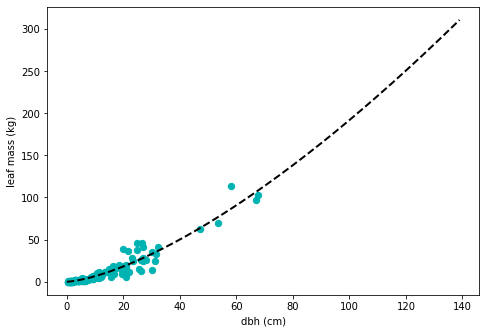

In [68]:
# dbh to leaf mass eq.
baad_mlfpft3 = baad_pft3.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_pars2, leafmass_cov2 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlfpft3['DBH (cm)'], ydata=baad_mlfpft3['m.lf'])
print(leafmass_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft3['DBH (cm)'], baad_mlfpft3['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_pars2), linestyle='--', linewidth=2, color='black')

In [69]:
mlf_dfpft3 = baad_mlfpft3[['DBH (cm)','m.lf']].copy()
mlf_covpft3 = mlf_dfpft3.cov()
mlf_covpft3

,DBH (cm),m.lf
DBH (cm),158.880278,221.889624
m.lf,221.889624,354.556772


(array([0.10538175, 0.01100139, 0.00405314, 0.00405314, 0.00173706,
        0.00231608, 0.00115804, 0.        , 0.00057902, 0.00057902,
        0.        , 0.        , 0.00057902, 0.00057902, 0.00057902]),
 array([2.01000000e-03, 7.54373200e+00, 1.50854540e+01, 2.26271760e+01,
        3.01688980e+01, 3.77106200e+01, 4.52523420e+01, 5.27940640e+01,
        6.03357860e+01, 6.78775080e+01, 7.54192300e+01, 8.29609520e+01,
        9.05026740e+01, 9.80443960e+01, 1.05586118e+02, 1.13127840e+02]),
 <a list of 15 Patch objects>)

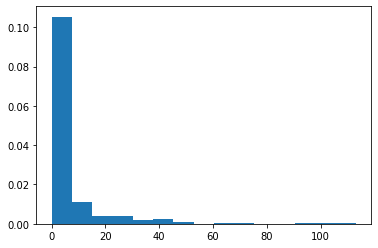

In [70]:
plt.hist(baad_pft3['m.lf'].dropna(), bins=15, density=True)

In [71]:
baad_pft3['m.lf'].describe()

count    229.000000
mean       6.655955
std       15.659585
min        0.002010
25%        0.133993
50%        0.606010
75%        5.030424
max      113.127840
Name: m.lf, dtype: float64

In [72]:
mlf_logpft3 = np.log(baad_pft3['m.lf'])
mlf_logpft3.describe()

count    229.000000
mean      -0.363191
std        2.443091
min       -6.209621
25%       -2.009964
50%       -0.500859
75%        1.615504
max        4.728519
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data generate samples to then calculate parameter values from

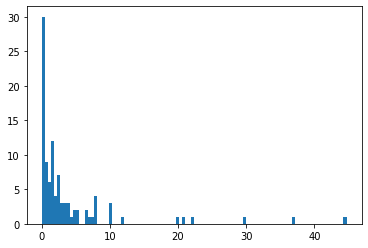

In [73]:
# Use the lognormal mean and std for each of the variables. (a.cp, a.lf, m.lf)

acp_pft3 = np.random.lognormal(mean=0.348389, sigma=1.438753, size=100)
plt.hist(acp_pft3, bins=100)
plt.show()

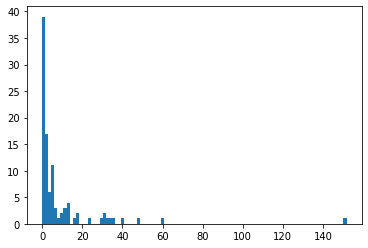

In [74]:
alf_pft3 = np.random.lognormal(mean=0.878136, sigma=2.120348, size=100)
plt.hist(alf_pft3, bins=100)
plt.show()

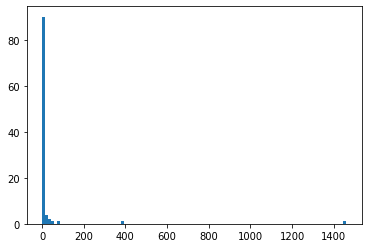

In [76]:
mlf_pft3 = np.random.lognormal(mean=-0.363191, sigma=2.443091, size=100)
plt.hist(mlf_pft3, bins=100)
plt.show()

In [77]:
np.log(1)

0.0

### 3.3 Diameter to above ground biomass (d2bagw)
Here I will test the Chojnacky (2014), the Saldarriaga et al. (1998) and the FATES 2 parameter power functions.

In [78]:
# From Delucia (2000), in montane ponderosa pine at dbh=50, agb=945. We will use this as a guide.
# We need to create an objective/cost function. Use RMSE for now.

def RMSE_d2bagw(agb_mod):
    RMSE_d2bagw = np.sqrt(np.mean((agb_mod-agb_obs)**2)) 
    return RMSE_d2bagw

# For d2abagw we will calculate the 

In [79]:
# Test the functions at dbh=50 to find RMSE for observed agb at dbh 50.
dbh_bagw = 50
agb_obs=945
allom_frac=0.6
c2b=2

# Chojnacky with default parameters for pines with density < 0.45
agb_choj = d2bagw_choj(dbh_bagw,-2.6177,2.4638)

# Saldarriaga with default parameters
#agb_sal = d2bagw_sal(dbh_bagw,0.284,0.57,1.94,1)

# 2-parameter with default parameters
agb_pow = d2bagw_pow(dbh_bagw,0.1,2.4)

#print("agb_choj =", agb_choj, "agb_sal=",agb_sal,"agb_pow=",agb_pow)
print("agb_choj =", agb_choj, "agb_pow=",agb_pow)

agb_choj = 1119.6173798341167 agb_pow= 597.720312368773


In [80]:
# Calculate the RMSE for each of the functions

RMSE_choj = RMSE_d2bagw(agb_choj)

#RMSE_sal = RMSE_d2bagw(agb_sal)

RMSE_pow = RMSE_d2bagw(agb_pow)

#print("choj RMSE=",RMSE_choj,", sal RMSE=",RMSE_sal,", power RMSE=",RMSE_pow)
print("choj RMSE=",RMSE_choj,", power RMSE=",RMSE_pow)

choj RMSE= 174.61737983411672 , power RMSE= 347.27968763122703


Well, they are all terrible.  How can I make them fit better?

In [84]:
# From the FIA data, calculate per acre above ground caron by multiplying the CARBON_AG * TPA_UNADJ

# Drop rows with na for CARBON_AG == 0.000
fia_agb = fia_pft3.dropna(subset = ['DRYBIO_BG']).copy()

#fia_agb['AGB'] = (fia_agb['CARBON_AG'] * fia_agb['TPA_UNADJ'])
fia_agb['AGB'] = fia_agb['CARBON_AG']

# Convert lbC/ac to gC/m^2 to match FATES

#fia_agb['AGB'] = (fia_agb['AGB'].values * 453.592 * 0.000247105)
fia_agb['AGB'] = (fia_agb['AGB'].values * 453.592)
fia_agb['AGB'].mean()


122057.94332447897

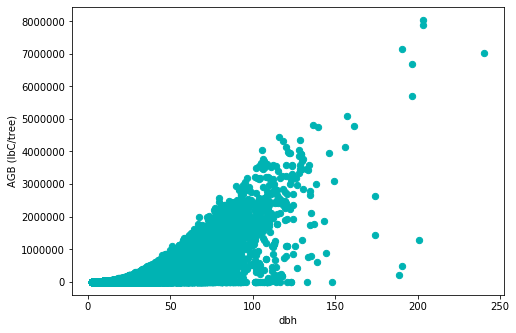

In [86]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (lbC/tree)')
ax.scatter(fia_pft3['DBH (cm)'], fia_pft3['CARBON_AG']* 453.592, s=40, color='#00b3b3', label='Data')

In [87]:
#fig = plt.figure()
#ax = fig.add_axes([0, 0, 1, 1])
#ax.set_xlabel('dbh')
#ax.set_ylabel('AGB (gC/m^2)')
#ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')
#ax.scatter(fia_agb['DBH (cm)'], fia_agb['AGB'], s=40, color='#00b3b3', label='Data')


In [71]:
#fia_pft1 = fia_agb.loc[(fia_2pfts['SPCD'] == 122) | (fia_agb['SPCD'] == 119) | (fia_agb['SPCD'] == 108)]
#fia_pft4 = fia_agb.loc[(fia_2pfts['SPCD'] == 263) | (fia_agb['SPCD'] == 202)]

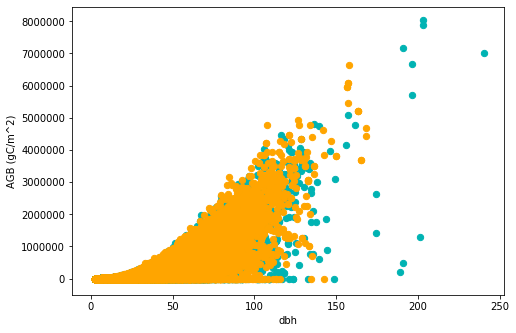

In [88]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_pft3['DBH (cm)'], fia_pft3['CARBON_AG']* 453.592, s=40, color='#00b3b3', label='Data')
ax.scatter(fia_pft4['DBH (cm)'], fia_pft4['CARBON_AG']* 453.592, s=40, color='#ffa500', label='Data')

In [89]:
fia_agb_pft3 = fia_pft3.dropna(subset=['CARBON_AG', 'DBH (cm)'])
fia_agb_pft3

,PLT_CN,COUNTYCD,INVYR,CONDID,AZIMUTH,SPCD,SPGRPCD,DIA,HT,CR,...,FGROWCFGS,TPA_UNADJ,DRYBIO_BG,CARBON_AG,CARBON_BG,DRYBIO_AG,SPECIES,HT (m),DBH (cm),DBH (m)
10,3156095010690,9,1991,1,100.0,242,22,6.7,39.0,55.0,...,0.160476,32.675003,27.119500,57.987927,13.559750,NaN,w_redcedar,11.8872,17.018,0.17018
13,3156095010690,9,1991,1,105.0,242,22,4.2,23.0,45.0,...,0.000000,60.000000,9.539426,19.686481,4.769713,NaN,w_redcedar,7.0104,10.668,0.10668
19,3156135010690,9,1991,1,138.0,19,12,2.3,17.0,45.0,...,0.000000,60.000000,1.965407,3.716620,0.982704,NaN,subap_fir,5.1816,5.842,0.05842
22,3156135010690,9,1991,1,329.0,19,12,4.4,25.0,45.0,...,0.000000,60.000000,9.312316,19.303246,4.656158,NaN,subap_fir,7.6200,11.176,0.11176
23,3156135010690,9,1991,1,345.0,19,12,2.4,13.0,35.0,...,0.000000,60.000000,2.174045,4.146916,1.087023,NaN,subap_fir,3.9624,6.096,0.06096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269628,354845325489998,59,2019,1,245.0,19,12,10.9,63.0,65.0,...,0.175366,6.018046,96.922864,211.839282,48.461432,423.678563,subap_fir,19.2024,27.686,0.27686
269638,354845325489998,59,2019,1,108.0,19,12,8.5,55.0,80.0,...,0.111282,6.018046,57.167249,123.730850,28.583625,247.461700,subap_fir,16.7640,21.590,0.21590
269639,354845325489998,59,2019,1,109.0,19,12,12.0,63.0,70.0,...,0.189499,6.018046,114.605679,251.276803,57.302840,502.553605,subap_fir,19.2024,30.480,0.30480
269680,354845331489998,59,2019,1,239.0,19,12,5.5,42.0,60.0,...,0.377402,6.018046,26.261349,55.440703,13.130675,110.881405,subap_fir,12.8016,13.970,0.13970


[5.13184863 1.98157824]
[ 1.85966718  1.3426554   1.98159385 -0.49989479]
[338.63070073   1.98159825]


/Users/kathrynmurenbeeld/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log


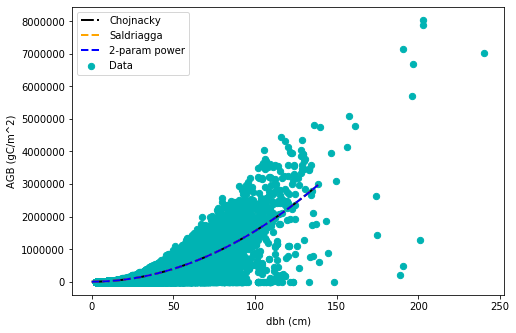

In [90]:
#fia_agb = fia_2pfts.dropna(subset=['AGB', 'DBH (cm)'])

# Define constants for the functions

# In d2bagw_sal
allom_frac = 0.6 
rho = 0.367 # Density of tree from USDA Survey of Tree Density, value for S. Idaho ponderosa pine
h_sal_mod = 29 # Observed height at dbh=50 from baad
# In d2bagw_pow
c2b = 2

pars_choj, cov_choj = curve_fit(f=d2bagw_choj, xdata=fia_agb_pft3['DBH (cm)'], ydata=fia_agb_pft3['CARBON_AG']* 453.592)
print(pars_choj)
pars_sal, cov_sal = curve_fit(f=d2bagw_sal, xdata=fia_agb_pft3['DBH (cm)'], ydata=fia_agb_pft3['CARBON_AG']* 453.592)
print(pars_sal)
pars_pow, cov_pow = curve_fit(f=d2bagw_pow, xdata=fia_agb_pft3['DBH (cm)'], ydata=fia_agb_pft3['CARBON_AG']* 453.592)
print(pars_pow)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('AGB (gC/m^2)')
ax.scatter(fia_agb_pft3['DBH (cm)'], fia_agb_pft3['CARBON_AG']* 453.592, s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2bagw_choj(np.arange(140), *pars_choj), linestyle='-.', linewidth=2, color='black', label="Chojnacky")
ax.plot(np.arange(140), d2bagw_sal(np.arange(140), *pars_sal), linestyle='--', linewidth=2, color='orange', label="Saldriagga")
ax.plot(np.arange(140), d2bagw_pow(np.arange(140), *pars_pow), linestyle='--', linewidth=2, color='blue', label="2-param power")

ax.legend()



### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [91]:
# Dbh to project crown area, 2pwr
d2ca_p1 = crownarea_pars[0]
d2ca_p2 = crownarea_pars[1]
# Dbh to leaf area, 2pwr
d2la_p1 = leafarea_pars[0]
d2la_p2 = leafarea_pars[1]

# d2lf_ediff = crown area p2 - leaf area p2
crown_exp_diff = crownarea_pars[1] - leafarea_pars[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1 = leafmass_pars[0]
d2blmax_ca_p2 = leafmass_pars[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1 = leafmass_pars2[0]
d2blmax_p2 = leafmass_pars2[1] # crown_to_dbh_exp(crownare_exp)


In [92]:
print(d2blmax_p1, d2blmax_p2)

0.4495555897206335 1.4655801233501118


In [93]:
# could create a range of p1 and p2, then a for loop to recalculate crown area or leaf 
# random
random.seed(10)

d2ca_p1_rand = np.random.normal(loc=d2ca_p1, scale=(d2ca_p1/10), size=100)
d2ca_p2_rand = np.random.normal(loc=d2ca_p2, scale=(d2ca_p2/10), size=100)


In [94]:
d2ca_params = pd.DataFrame({'d2ca_p1': d2ca_p1_rand, 'd2ca_p2': d2ca_p2_rand}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params.head()

,d2ca_p1,d2ca_p2
0,0.267910,0.982852
1,0.300343,1.149807
2,0.318712,1.202325
3,0.338600,1.153632
4,0.308917,1.088949


In [95]:
# random
random.seed(10)

d2la_p1_rand = np.random.normal(loc=d2la_p1, scale=(d2la_p1/10), size=100)
d2la_p2_rand = np.random.normal(loc=d2la_p2, scale=(d2la_p2/10), size=100)

In [96]:
d2la_params = pd.DataFrame({'d2la_p1': d2la_p1_rand, 'd2la_p2': d2la_p2_rand}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params.head()

,d2la_p1,d2la_p2
0,0.431616,1.885192
1,0.452362,1.774900
2,0.448141,2.313690
3,0.480814,2.008556
4,0.524024,2.013262


In [97]:
# random
random.seed(10)

d2blmax_ca_p1_rand = np.random.normal(loc=d2blmax_ca_p1, scale=(d2blmax_ca_p1/10), size=100)
d2blmax_ca_p2_rand = np.random.normal(loc=d2blmax_ca_p2, scale=(d2blmax_ca_p2/10), size=100)

In [98]:
d2blmax_ca_params = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_rand, 'd2blmax_ca_p2': d2blmax_ca_p2_rand}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.244517,1.447320
1,0.241085,1.499559
2,0.242225,1.407998
3,0.241044,1.689093
4,0.197175,1.543473


In [99]:
# random
random.seed(10)

d2blmax_p1_rand = np.random.normal(loc=d2blmax_p1, scale=(d2blmax_p1/10), size=100)
d2blmax_p2_rand = np.random.normal(loc=d2blmax_p2, scale=(d2blmax_p2/10), size=100)

In [100]:
d2blmax_params = pd.DataFrame({'d2blmax_p1': d2blmax_p1_rand, 'd2blmax_p2': d2blmax_p2_rand}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params.head()

,d2blmax_p1,d2blmax_p2
0,0.415920,1.459882
1,0.407395,1.156710
2,0.480081,1.442819
3,0.478955,1.325714
4,0.494378,1.630872


### Calculate crown area from the random parameters

In [101]:
# Calc crown area from random params

ca_rand_p = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_rand[i], d2ca_p2_rand[i])
    ca_rand_p.append(test_ca)

ca_opt = carea_2pwr(np.arange(0,90,5), d2ca_p1, d2ca_p2)

In [102]:
print(d2ca_p1_rand[1], d2ca_p2_rand[1], ca_rand_p[1])

0.30034250408773744 1.1498071191875363 [ 0.          1.91116192  4.24056687  6.75919382  9.40914906 12.16124874
 14.997585   17.90594422 20.87741772 23.90519635 26.98389285 30.10913006
 33.27727564 36.48526301 39.73046604 43.01060851 46.32369706 49.66797045]


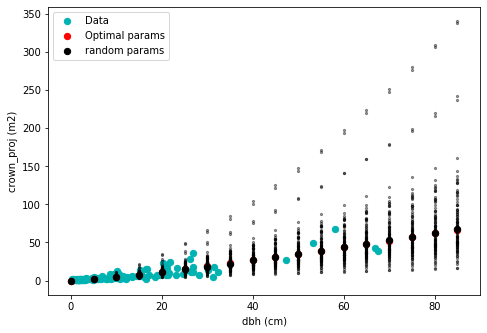

In [103]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft3['DBH (cm)'], baad_acppft3['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 4.,  5.,  7., 11., 13., 14., 15., 18.,  9.,  4.]),
 array([0.22549308, 0.23746126, 0.24942944, 0.26139762, 0.2733658 ,
        0.28533398, 0.29730216, 0.30927034, 0.32123852, 0.33320669,
        0.34517487]),
 <a list of 10 Patch objects>)

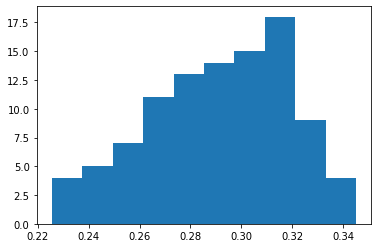

In [104]:
plt.hist(d2ca_p1_rand)

(array([ 3.,  4., 12., 25., 22., 17., 11.,  2.,  1.,  3.]),
 array([0.93083943, 0.9982603 , 1.06568116, 1.13310203, 1.2005229 ,
        1.26794376, 1.33536463, 1.4027855 , 1.47020637, 1.53762723,
        1.6050481 ]),
 <a list of 10 Patch objects>)

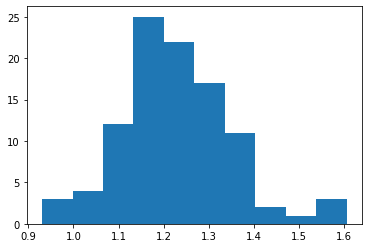

In [105]:
plt.hist(d2ca_p2_rand)

In [114]:
# d2ca_p2 > 1.77 caused problems
d2ca_params.index[d2ca_params['d2ca_p2'] >= 1.4].to_list()

[36, 37, 48, 51, 59, 86]

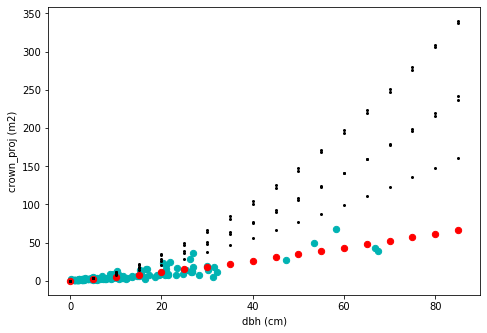

In [117]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft3['DBH (cm)'], baad_acppft3['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_p[59], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[86], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[36], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[48], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[37], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_p[51], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[37], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[47], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[64], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[75], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[79], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[82], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[88], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_p[98], s=4, color='black', label='random params')

In [121]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_cleanpft3 = d2ca_params.drop([d2ca_params.index[36], d2ca_params.index[48],d2ca_params.index[51], 
                                      d2ca_params.index[59], d2ca_params.index[86]])

In [122]:
len(d2ca_params_cleanpft3)

95

In [123]:
# read out to a csv for use in the traits matrix
#d2ca_params_cleanpft3.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_pft3_20211004.csv', index=False)


### Calculate leaf area from the random parameters

In [124]:
la_rand_p = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_rand[i], d2la_p2_rand[i])
    la_rand_p.append(test_la)

la_opt = carea_2pwr(np.arange(0,90,5), d2la_p1, d2la_p2)

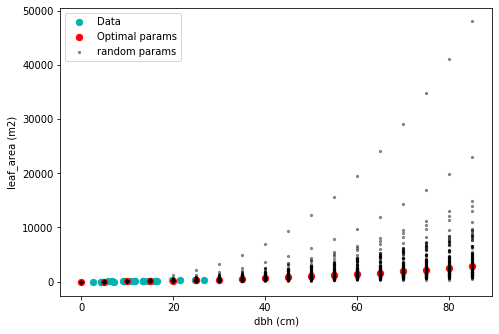

In [125]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft3['DBH (cm)'], baad_alfpft3['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 7., 11.,  9., 18., 22., 10., 11.,  5.,  3.,  4.]),
 array([0.38360541, 0.40330672, 0.42300803, 0.44270934, 0.46241064,
        0.48211195, 0.50181326, 0.52151456, 0.54121587, 0.56091718,
        0.58061849]),
 <a list of 10 Patch objects>)

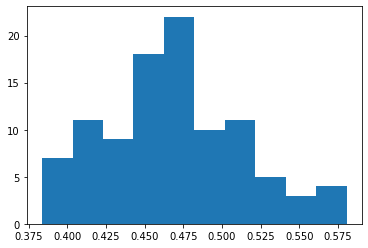

In [126]:
plt.hist(d2la_p1_rand)

(array([ 1.,  5., 17., 23., 22., 15., 10.,  5.,  1.,  1.]),
 array([1.51869171, 1.62468913, 1.73068655, 1.83668397, 1.94268138,
        2.0486788 , 2.15467622, 2.26067364, 2.36667106, 2.47266848,
        2.5786659 ]),
 <a list of 10 Patch objects>)

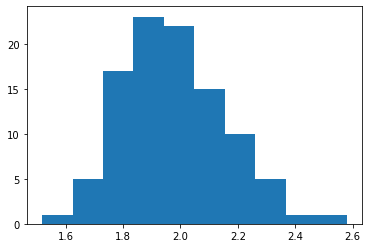

In [127]:
plt.hist(d2la_p2_rand)

In [130]:
# d2la_p2 > 1.95 caused problems
d2la_params.index[d2la_params['d2la_p2'] > 2.3].to_list()

[2, 29, 51, 53, 59]

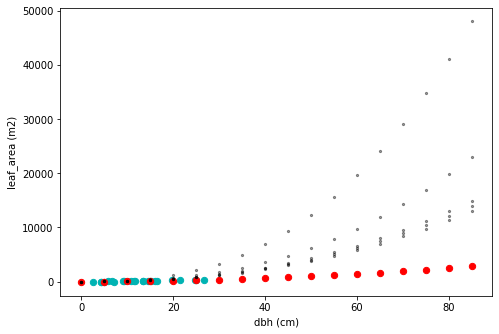

In [131]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft3['DBH (cm)'], baad_alfpft3['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_p[53], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_p[59], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[2], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[29], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_p[51], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[37], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[64], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[65], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[71], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[86], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[89], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_p[98], s=5, color='black', alpha=0.4)


In [132]:
d2la_params_cleanpft3 = d2la_params.drop([d2la_params.index[2], d2la_params.index[29],d2la_params.index[51], 
                                      d2la_params.index[53], d2la_params.index[59]])


len(d2la_params_cleanpft3)

95

In [133]:
# read out to a csv for use in the traits matrix
#d2la_params_cleanpft3.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean__pft3_20211004.csv', index=False)


### Calculate leaf mass from the random parameters

In [134]:
bl_rand_p = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_rand[i], d2blmax_p2_rand[i])
    bl_rand_p.append(test_bl)

bl_opt = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1, d2blmax_p2)

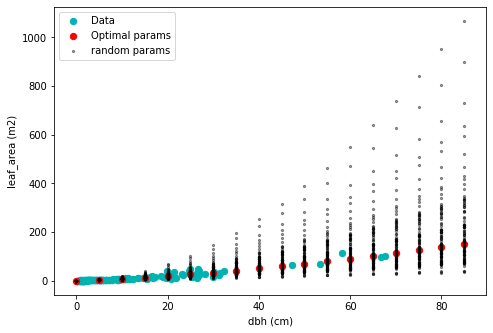

In [135]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlfpft3['DBH (cm)'], baad_mlfpft3['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_p[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 2.,  6., 14., 22., 20., 15., 13.,  5.,  1.,  2.]),
 array([0.34470467, 0.36866964, 0.39263461, 0.41659959, 0.44056456,
        0.46452953, 0.48849451, 0.51245948, 0.53642445, 0.56038943,
        0.5843544 ]),
 <a list of 10 Patch objects>)

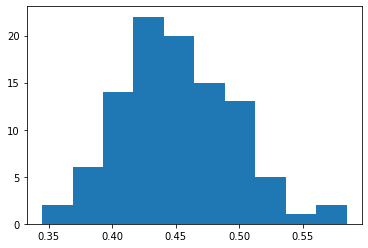

In [136]:
plt.hist(d2blmax_p1_rand)

(array([ 3.,  7., 13., 21., 19., 16., 12.,  5.,  2.,  2.]),
 array([1.15670969, 1.23245276, 1.30819582, 1.38393889, 1.45968196,
        1.53542503, 1.61116809, 1.68691116, 1.76265423, 1.83839729,
        1.91414036]),
 <a list of 10 Patch objects>)

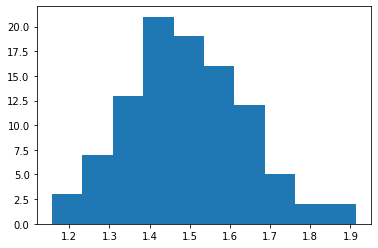

In [137]:
plt.hist(d2blmax_p2_rand)

In [141]:
# d2blmax_p2 > 2.2 caused problems
d2blmax_params.index[d2blmax_params['d2blmax_p2'] > 1.7].to_list()

[14, 16, 24, 45, 48, 51, 52, 78, 91]

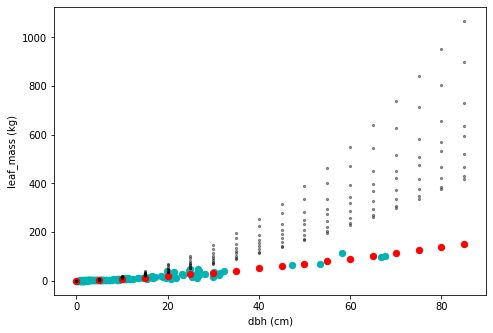

In [142]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlfpft3['DBH (cm)'], baad_mlfpft3['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_opt, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_p[14], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_p[24], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[51], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[52], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[91], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), bl_rand_p[14], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[16], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[45], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[48], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_p[78], s=5, color='black', alpha=0.4)

In [143]:
d2blmax_params_cleanpft3 = d2blmax_params.drop([d2blmax_params.index[14], d2blmax_params.index[16],d2blmax_params.index[24], 
                                      d2blmax_params.index[45], d2blmax_params.index[48], d2blmax_params.index[51],
                                           d2blmax_params.index[52], d2blmax_params.index[78], d2blmax_params.index[91]])


len(d2blmax_params_cleanpft3)


91

In [144]:
# read out to a csv for use in the traits matrix
#d2blmax_params_cleanpft3.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean__pft3_20211004.csv', index=False)


#### Repeat for pft4

1. Get optimal param values for PFT4
2. From distribution of PFT4 traits create synthetic data
3. Get optimal parameters from synthetic data
4. Refit
5. Clean up data that would create crazy values

[0.3689763  0.98105649]


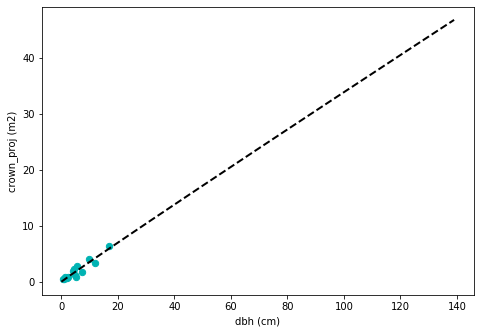

In [146]:
# Crown area

baad_acppft4 = baad_pft4.dropna(subset=['a.cp', 'DBH (cm)'])
crownarea_pars4, crownarea_cov4 = curve_fit(f=carea_2pwr, xdata=baad_acppft4['DBH (cm)'], ydata=baad_acppft4['a.cp'])
print(crownarea_pars4)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft4['DBH (cm)'], baad_acppft4['a.cp'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *crownarea_pars4), linestyle='--', linewidth=2, color='black')

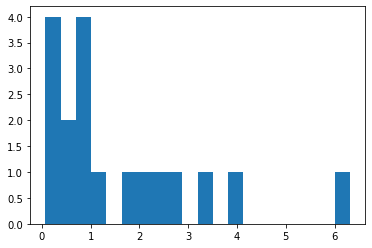

In [147]:
plt.hist(baad_pft4['a.cp'].dropna(), bins=20)
plt.show()

In [148]:
baad_pft4['a.cp'].describe()

count    18.000000
mean      1.601317
std       1.655472
min       0.072966
25%       0.465340
50%       0.893832
75%       2.209407
max       6.310819
Name: a.cp, dtype: float64

In [149]:
acp_logpft4 = np.log(baad_pft4['a.cp'])
acp_logpft4.describe()

count    18.000000
mean     -0.082492
std       1.186128
min      -2.617763
25%      -0.765572
50%      -0.112237
75%       0.790716
max       1.842265
Name: a.cp, dtype: float64

In [150]:
# leaf area

baad_alfpft4 = baad_pft4.dropna(subset=['a.lf', 'DBH (cm)'])
leafarea_pars4, leafarea_cov4 = curve_fit(f=carea_2pwr, xdata=baad_alfpft4['DBH (cm)'], ydata=baad_alfpft4['a.lf'])
print(leafarea_pars2)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf area (m2)')
ax.scatter(baad_alfpft4['DBH (cm)'], baad_alfpft4['a.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafarea_pars4), linestyle='--', linewidth=2, color='black')
#ax.set_xlim(0,100)

ValueError: `ydata` must not be empty!

In [151]:
baad_alfpft4.head()

,species,location,h.t,d.bh,a.lf,a.cp,m.lf,ma.ilf,n.lf,m.so,DBH (cm)


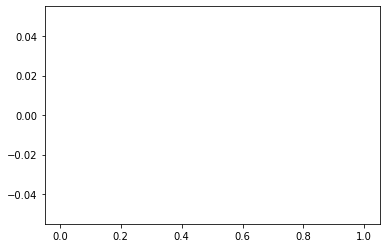

In [152]:
plt.hist(baad_pft4['a.lf'].dropna(), bins=15)
plt.show()

In [153]:
baad_pft4['a.lf'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: a.lf, dtype: float64

In [154]:
alf_logpft4 = np.log(baad_pft4['a.lf'])
alf_logpft4.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: a.lf, dtype: float64

In [155]:
# Calculate the leaf crown exponent difference
leaf_crown_exponent_diffpft4 = crownarea_pars4[1] - leafarea_pars4[1]
print(leaf_crown_exponent_diffpft4)

NameError: name 'leafarea_pars4' is not defined

[0.12168017 1.11406368]


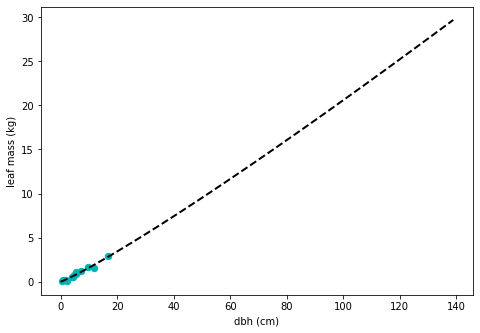

In [158]:
# Leaf mass

baad_mlfpft4 = baad_pft4.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_parspft4, leafmass_covpft4 = curve_fit(f=carea_2pwr, xdata=baad_mlfpft4['DBH (cm)'], ydata=baad_mlfpft4['m.lf'])
print(leafmass_parspft4)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft4['DBH (cm)'], baad_mlfpft4['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), carea_2pwr(np.arange(140), *leafmass_parspft4), linestyle='--', linewidth=2, color='black')

[0.24336041 1.11406356]


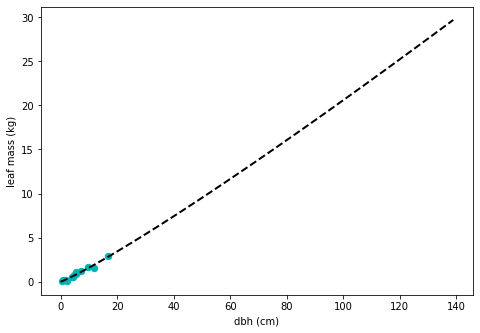

In [159]:
baad_mlfpft4 = baad_pft4.dropna(subset=['m.lf', 'DBH (cm)'])
leafmass_parspft42, leafmass_covpft42 = curve_fit(f=d2blmax_2pwr, xdata=baad_mlfpft4['DBH (cm)'], ydata=baad_mlfpft4['m.lf'])
print(leafmass_parspft42)
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf mass (kg)')
ax.scatter(baad_mlfpft4['DBH (cm)'], baad_mlfpft4['m.lf'], s=40, color='#00b3b3', label='Data')
ax.plot(np.arange(140), d2blmax_2pwr(np.arange(140), *leafmass_parspft42), linestyle='--', linewidth=2, color='black')

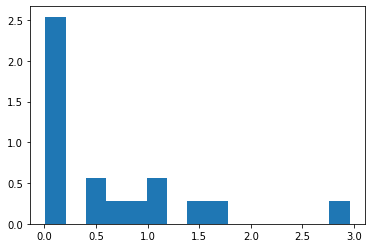

In [160]:
plt.hist(baad_pft4['m.lf'].dropna(), bins=15, density=True)
plt.show()

In [161]:
baad_pft4['m.lf'].describe()

count    18.000000
mean      0.667561
std       0.776277
min       0.008981
25%       0.106267
50%       0.386082
75%       1.009147
max       2.959286
Name: m.lf, dtype: float64

In [162]:
mlf_logpft4 = np.log(baad_pft4['m.lf'])
mlf_logpft4.describe()

count    18.000000
mean     -1.291121
std       1.660233
min      -4.712613
25%      -2.248238
50%      -1.080679
75%       0.005142
max       1.084948
Name: m.lf, dtype: float64

### From the distributions of the leaf and crown data, generate samples to then calculate parameter values from

In [163]:
acppft4 = np.random.lognormal(mean=-0.082492, sigma=1.186128, size=100)
#plt.hist(acppft2, bins=100)
#plt.show()

In [191]:
# No a.lf, area leaf, data for PFT4

#alfpft4 = np.random.lognormal(mean=3.514120, sigma=1.914397, size=100)
#plt.hist(alfpft2, bins=100)
#plt.show()

In [164]:
mlfpft4 = np.random.lognormal(mean=-1.291121, sigma=1.660233, size=100)
#plt.hist(mlfpft2, bins=100)
#plt.show()

In [193]:
# Oh yeah, I forget that isn't useful because I need the corresponding dbhs to go with the calculated leaf and canopy values

### For the d2ca, d2blmax, and d2agb chose a mean and variance and ramdonly sample 100 times. These will be brought over to the SCGSR Trait Matrix

In [165]:
# Remember for PFT2. Should probably take the time to name things better before going on GitHub

# Dbh to project crown area, 2pwr
d2ca_p1pft4 = crownarea_pars4[0]
d2ca_p2pft4 = crownarea_pars4[1]
# Dbh to leaf area, 2pwr
#d2la_p1pft4 = leafarea_pars4[0]
#d2la_p2pft4 = leafarea_pars4[1]

# d2lf_ediff = crown area p2 - leaf area p2
#crown_exp_diffpft4 = crownarea_pars4[1] - leafarea_pars4[1]

# d2leaf mass, carea 2pwr
d2blmax_ca_p1pft4 = leafmass_parspft4[0]
d2blmax_ca_p2pft4 = leafmass_parspft4[1]

# Dbh to leaf biomass d2blmax, 2pwr
d2blmax_p1pft4 = leafmass_parspft42[0]
d2blmax_p2pft4 = leafmass_parspft42[1] # crown_to_dbh_exp(crownare_exp)

In [166]:
random.seed(10)

d2ca_p1_randpft4 = np.random.normal(loc=d2ca_p1pft4, scale=(d2ca_p1pft4/10), size=100)
d2ca_p2_randpft4 = np.random.normal(loc=d2ca_p2pft4, scale=(d2ca_p2pft4/10), size=100)

d2ca_params_pft4 = pd.DataFrame({'d2ca_p1': d2ca_p1_randpft4, 'd2ca_p2': d2ca_p2_randpft4}, columns = ['d2ca_p1', 'd2ca_p2'])
d2ca_params_pft4.head()

,d2ca_p1,d2ca_p2
0,0.355769,1.033963
1,0.426594,1.069990
2,0.346506,1.023651
3,0.310907,0.924015
4,0.367717,0.888677


In [167]:
# random
random.seed(10)

d2la_p1_randpft4 = np.random.normal(loc=d2la_p1pft4, scale=(d2la_p1pft4/10), size=100)
d2la_p2_randpft4 = np.random.normal(loc=d2la_p2pft4, scale=(d2la_p2pft4/10), size=100)

d2la_params_pft4 = pd.DataFrame({'d2la_p1': d2la_p1_randpft4, 'd2la_p2': d2la_p2_randpft4}, columns = ['d2la_p1', 'd2la_p2'])
d2la_params_pft4.head()

NameError: name 'd2la_p1pft4' is not defined

In [168]:
# random
random.seed(10)

d2blmax_ca_p1_randpft4 = np.random.normal(loc=d2blmax_ca_p1pft4, scale=(d2blmax_ca_p1pft4/10), size=100)
d2blmax_ca_p2_randpft4 = np.random.normal(loc=d2blmax_ca_p2pft4, scale=(d2blmax_ca_p2pft4/10), size=100)

d2blmax_ca_params_pft4 = pd.DataFrame({'d2blmax_ca_p1': d2blmax_ca_p1_randpft4, 'd2blmax_ca_p2': d2blmax_ca_p2_randpft4}, 
                                 columns = ['d2blmax_ca_p1', 'd2blmax_ca_p2'])
d2blmax_ca_params_pft4.head()

,d2blmax_ca_p1,d2blmax_ca_p2
0,0.111607,1.020622
1,0.098141,1.087898
2,0.127852,1.307212
3,0.102390,1.132891
4,0.135208,0.850912


In [169]:
random.seed(10)

d2blmax_p1_randpft4 = np.random.normal(loc=d2blmax_p1pft4, scale=(d2blmax_p1pft4/10), size=100)
d2blmax_p2_randpft4 = np.random.normal(loc=d2blmax_p2pft4, scale=(d2blmax_p2pft4/10), size=100)

d2blmax_params_pft4 = pd.DataFrame({'d2blmax_p1': d2blmax_p1_randpft4, 'd2blmax_p2': d2blmax_p2_randpft4}, 
                                 columns = ['d2blmax_p1', 'd2blmax_p2'])
d2blmax_params_pft4.head()

,d2blmax_p1,d2blmax_p2
0,0.242710,1.151955
1,0.278572,1.292721
2,0.254554,1.033474
3,0.242301,0.954084
4,0.262172,1.160209


### Calculate crown area from the random parameters

In [170]:
# Calc crown area from random params

ca_rand_pft4 = []

for i in range(100):

    test_ca = carea_2pwr(np.arange(0,90,5), d2ca_p1_randpft4[i], d2ca_p2_randpft4[i])
    ca_rand_pft4.append(test_ca)

ca_optpft4 = carea_2pwr(np.arange(0,90,5), d2ca_p1pft4, d2ca_p2pft4)

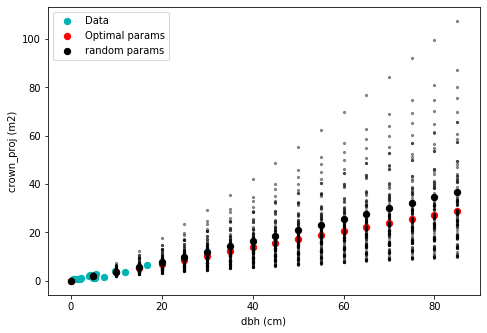

In [173]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft4['DBH (cm)'], baad_acppft4['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_optpft4, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[7], s=40, color='black', label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), ca_rand_pft4[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 3.,  3.,  9., 13., 24., 20., 15.,  8.,  2.,  3.]),
 array([0.26409201, 0.28504149, 0.30599098, 0.32694047, 0.34788996,
        0.36883945, 0.38978894, 0.41073843, 0.43168791, 0.4526374 ,
        0.47358689]),
 <a list of 10 Patch objects>)

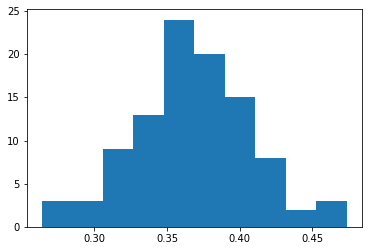

In [174]:
plt.hist(d2ca_p1_randpft4)

In [182]:
# d2ca_p1 > 0.45 caused problems
d2ca_params_pft4.index[d2ca_params_pft4['d2ca_p1'] >= 0.45].to_list()

[9, 72, 94]

(array([ 6.,  9.,  8., 12., 17., 22., 15.,  4.,  3.,  4.]),
 array([0.73677971, 0.78792005, 0.83906038, 0.89020072, 0.94134105,
        0.99248139, 1.04362172, 1.09476206, 1.14590239, 1.19704273,
        1.24818306]),
 <a list of 10 Patch objects>)

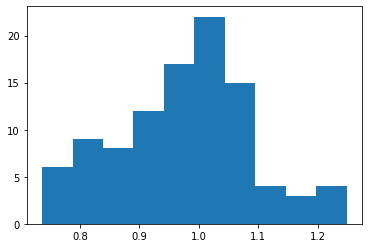

In [175]:
plt.hist(d2ca_p2_randpft4)

In [179]:
# d2ca_p2 > 1.77 caused problems
d2ca_params_pft4.index[d2ca_params_pft4['d2ca_p2'] >= 1.12].to_list()

[16, 25, 30, 38, 68, 75, 82]

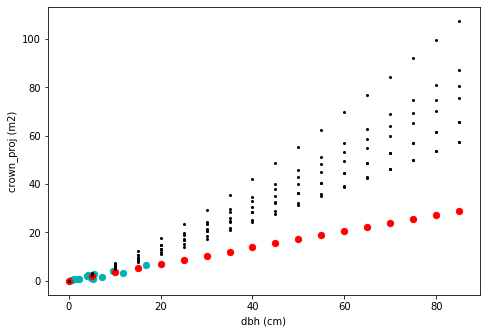

In [183]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('crown_proj (m2)')
ax.scatter(baad_acppft4['DBH (cm)'], baad_acppft4['a.cp'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), ca_optpft4, s=40, color='red', label='Optimal params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[16], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[9], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[30], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[38], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[68], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[75], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[82], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[72], s=4, color='black', label='random params')
ax.scatter(np.arange(0,90,5), ca_rand_pft4[94], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[98], s=4, color='black', label='random params')
#ax.scatter(np.arange(0,90,5), ca_rand_pft2[99], s=4, color='black', label='random params')

In [184]:
# drop the problem values from the dataframe and save to a csv

d2ca_params_clean_pft4 = d2ca_params_pft4.drop([d2ca_params_pft4.index[9], d2ca_params_pft4.index[30],
                                                d2ca_params_pft4.index[38], d2ca_params_pft4.index[68], 
                                                d2ca_params_pft4.index[75], d2ca_params_pft4.index[82],
                                               d2ca_params_pft4.index[72], d2ca_params_pft4.index[94]])



In [185]:
len(d2ca_params_clean_pft4)

92

In [186]:
# read out to a csv for use in the traits matrix
d2ca_params_clean_pft4.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2ca_params_clean_pft4_20211004.csv', index=False)

In [233]:
la_rand_pft4 = []

for i in range(100):

    test_la = carea_2pwr(np.arange(0,90,5), d2la_p1_randpft4[i], d2la_p2_randpft4[i])
    la_rand_pft4.append(test_la)

la_optpft2 = carea_2pwr(np.arange(0,90,5), d2la_p1pft2, d2la_p2pft2)

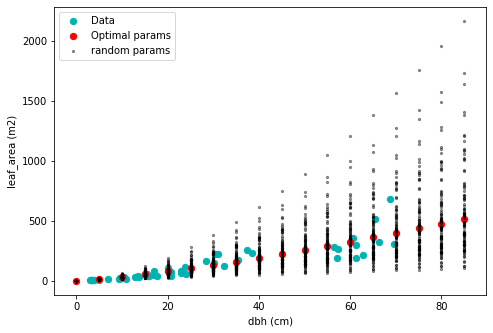

In [234]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft2['DBH (cm)'], baad_alfpft2['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), la_rand_pft2[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 4.,  7.,  8., 12., 18., 15., 15., 10.,  8.,  3.]),
 array([1.09099608, 1.16125433, 1.23151258, 1.30177084, 1.37202909,
        1.44228734, 1.51254559, 1.58280384, 1.6530621 , 1.72332035,
        1.7935786 ]),
 <a list of 10 Patch objects>)

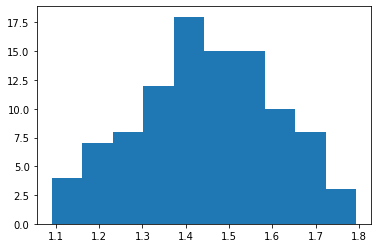

In [235]:
plt.hist(d2la_p1_randpft2)

(array([ 2.,  1.,  8., 19., 21., 24., 11.,  7.,  6.,  1.]),
 array([0.95153682, 1.02391039, 1.09628396, 1.16865752, 1.24103109,
        1.31340466, 1.38577823, 1.45815179, 1.53052536, 1.60289893,
        1.6752725 ]),
 <a list of 10 Patch objects>)

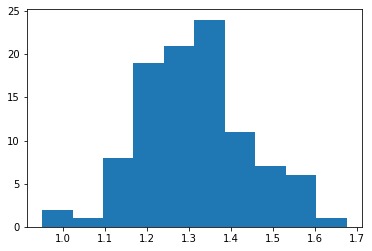

In [236]:
plt.hist(d2la_p2_randpft2)

In [239]:
# d2la_p2 > 1.95 caused problems
d2la_params_pft2.index[d2la_params_pft2['d2la_p2'] > 1.5].to_list()

[28, 59, 60, 66, 67, 88, 97]

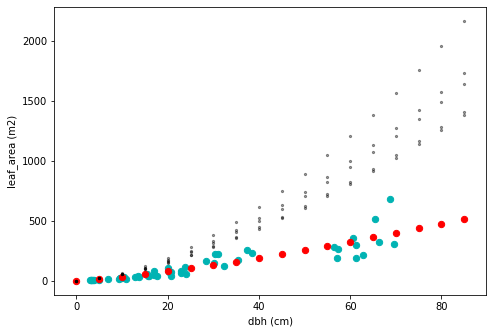

In [244]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_alfpft2['DBH (cm)'], baad_alfpft2['a.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), la_optpft2, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[66], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), la_rand_pft2[67], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[97], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_pft2[28], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), la_rand_pft2[59], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[60], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), la_rand_pft2[88], s=5, color='black', alpha=0.4)

In [248]:
d2la_params_clean_pft2 = d2la_params_pft2.drop([d2la_params_pft2.index[60], d2la_params_pft2.index[66],
                                                d2la_params_pft2.index[67], d2la_params_pft2.index[88], 
                                                d2la_params_pft2.index[97]])


len(d2la_params_clean_pft2)

95

In [249]:
# read out to a csv for use in the traits matrix
#d2la_params_clean_pft2.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2la_params_clean_pft2_20210727.csv', index=False)


In [187]:
bl_rand_pft4 = []

for i in range(100):

    test_bl = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1_randpft4[i], d2blmax_p2_randpft4[i])
    bl_rand_pft4.append(test_bl)

bl_optpft4 = d2blmax_2pwr(np.arange(0,90,5), d2blmax_p1pft4, d2blmax_p2pft4)

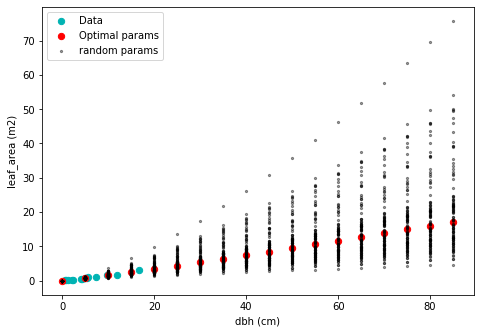

In [188]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_area (m2)')
ax.scatter(baad_mlfpft4['DBH (cm)'], baad_mlfpft4['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_optpft4, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_pft4[7], s=5, color='black', alpha=0.4, label='random params')
for i in range(100):
    ax.scatter(np.arange(0,90,5), bl_rand_pft4[i], s=5, color='black', alpha=0.4)
#ax.set_ylim(0,150)
plt.legend()

(array([ 5.,  8., 23., 19., 22., 14.,  6.,  2.,  0.,  1.]),
 array([0.19427336, 0.20778838, 0.2213034 , 0.23481842, 0.24833343,
        0.26184845, 0.27536347, 0.28887849, 0.3023935 , 0.31590852,
        0.32942354]),
 <a list of 10 Patch objects>)

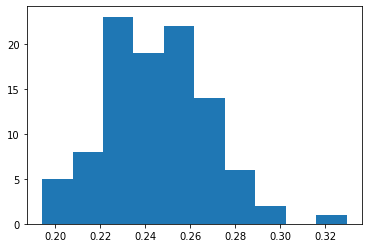

In [189]:
plt.hist(d2blmax_p1_randpft4)

(array([ 3.,  4., 10., 21., 17., 22.,  5.,  9.,  6.,  3.]),
 array([0.85693869, 0.91254196, 0.96814523, 1.02374849, 1.07935176,
        1.13495503, 1.19055829, 1.24616156, 1.30176483, 1.3573681 ,
        1.41297136]),
 <a list of 10 Patch objects>)

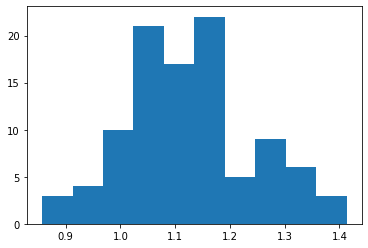

In [190]:
plt.hist(d2blmax_p2_randpft4)

In [196]:
# d2blmax_p2 > 2.2 caused problems
d2blmax_params_pft4.index[d2blmax_params_pft4['d2blmax_p2'] > 1.28].to_list()

[1, 16, 30, 46, 47, 53, 60, 61, 72, 79, 93]

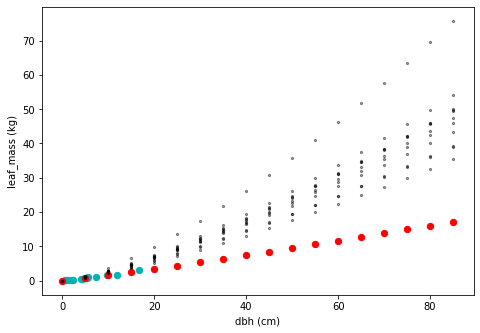

In [197]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlabel('dbh (cm)')
ax.set_ylabel('leaf_mass (kg)')
ax.scatter(baad_mlfpft4['DBH (cm)'], baad_mlfpft4['m.lf'], s=40, color='#00b3b3', label='Data')
ax.scatter(np.arange(0,90,5), bl_optpft4, s=40, color='red', label='Optimal params')
ax.scatter(np.arange(0,90,5), bl_rand_pft4[16], s=5, color='black', alpha=0.4, label='random params')
ax.scatter(np.arange(0,90,5), bl_rand_pft4[30], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[46], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[47], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[53], s=5, color='black', alpha=0.4)

ax.scatter(np.arange(0,90,5), bl_rand_pft4[60], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[61], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[72], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[93], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[1], s=5, color='black', alpha=0.4)
ax.scatter(np.arange(0,90,5), bl_rand_pft4[79], s=5, color='black', alpha=0.4)
#ax.scatter(np.arange(0,90,5), bl_rand_pft2[77], s=5, color='black', alpha=0.4)


In [198]:
d2blmax_params_clean_pft4 = d2blmax_params_pft4.drop([d2blmax_params_pft4.index[1], d2blmax_params_pft4.index[16],
                                                    d2blmax_params_pft4.index[30], d2blmax_params_pft4.index[46],
                                                     d2blmax_params_pft4.index[47], d2blmax_params_pft4.index[53],
                                                     d2blmax_params_pft4.index[60], d2blmax_params_pft4.index[61],
                                                     d2blmax_params_pft4.index[72], d2blmax_params_pft4.index[79],
                                                     d2blmax_params_pft4.index[93]])


len(d2blmax_params_clean_pft4)


89

In [199]:
# read out to a csv for use in the traits matrix
#d2blmax_params_clean_pft4.to_csv('/Users/kathrynmurenbeeld/Desktop/Desktop - Kathryn’s MacBook Pro/CLM/FATES/SCGSR_PARAMS/d2blmax_params_clean_pft4_20211004.csv', index=False)